In [56]:
from riversim import *

outer_boundary = Boundary()
outer_boundary.vertices.extend([Point(0.13, 0.011), Point(0.31, 0), 
    Point(0.74, 0.15), Point(0.95, 0.35), Point(0.8, 0.75), 
    Point(0.47, 0.85), Point(0.152, 0.76), Point(0, 0.5), Point(0.025, 0.3)])
outer_boundary.lines.extend([Line(0, 1, 1), Line(1, 2, 1), 
    Line(2, 3, 1), Line(3, 4, 1), Line(4, 5, 2), Line(5, 6, 2), 
    Line(6, 7, 1), Line(7, 8, 1), Line(8, 0, 1)])

inner_boundary = Boundary()
inner_boundary.vertices.extend([Point(0.3, 0.7), Point(0.5, 0.76), Point(0.65, 0.7), Point(0.66, 0.59)])
inner_boundary.lines.extend([Line(0, 1, 1), Line(1, 2, 3), 
    Line(2, 3, 3), Line(3, 0, 1)])

region = Region()
region[1] = outer_boundary; region[2] = inner_boundary
region.holes.append(Point(0.4, 0.7))

sources = Sources()
sources[1] = t_source_coord(1, 1) 
sources[2] = t_source_coord(1, 8) 
sources[3] = t_source_coord(2, 3)

In [48]:
import matplotlib.pyplot as plt

x = []
y = []
for boundary_pr in region:
    x = x + [v.x for v in boundary_pr.data().vertices]
    y = y + [v.y for v in boundary_pr.data().vertices]
    x.append(boundary_pr.data().vertices[0].x)
    #y.append(boundary_pr.data().vertices[0].y)

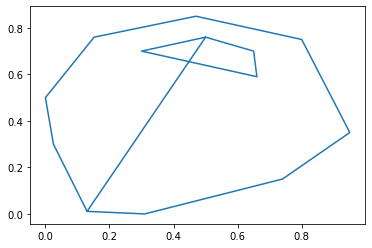

In [49]:
plt.plot(x, y)

In [41]:
rivers = Rivers()
rivers.initialize(region.getSourcesIdsPointsAndAngles(sources))

In [42]:
rivers_ids = t_sources_ids(); rivers_ids.extend([1, 2, 3])
ds = 0.01
tip_points = t_PolarList(); tip_points.extend([Polar(ds, 0), Polar(ds, 0), Polar(ds, 0)])
boundaries_ids = t_boundaries_ids(); boundaries_ids.extend([1, 2, 1])
rivers.addPolars(rivers_ids, tip_points, boundaries_ids)
rivers.addPolars(rivers_ids, tip_points, boundaries_ids)

sub_branch_ids = rivers.createSubBranches(1, -3.1415/5, 3.1415/5)


In [6]:
RegionParams()

{
    "ignored_smoothness_length": 0.01,
    "river_boundary_id": 100,
    "river_width": 1e-07,
    "smoothness_degree": 0.2
}

In [50]:
region_params = RegionParams()
region_params.smoothness_degree = 0.2
region_params.river_width = 1e-8
boundary = BoundaryGenerator(sources, region, rivers, region_params)

In [51]:
import matplotlib.pyplot as plt

x = []
y = []
x = x + [v.x for v in boundary.vertices]
y = y + [v.y for v in boundary.vertices]
x.append(boundary.vertices[0].x)
y.append(boundary.vertices[0].y)

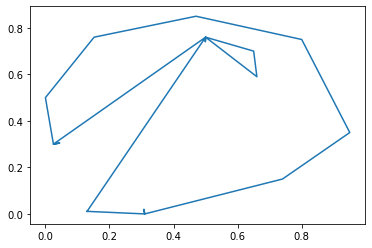

In [52]:
plt.plot(x, y)

In [20]:
mesh_params = MeshParams()
mesh_params.max_area = 1e6
mesh_params.min_area = 6e-7
mesh_params.max_edge = 1
mesh_params.min_edge = 8e-12
mesh_params.ratio = 2.3
mesh_params.refinment_radius = 5e-3
mesh_params.exponant = 1
mesh_params.sigma = 1.9

In [21]:
triangle = Triangle(mesh_params)

In [22]:
mesh = triangle.generate(boundary, region.holes)

In [23]:
mesh.write("lala.msh")

In [66]:
solver_params = SolverParams()
solver_params.field_value = 1
solver_params.quadrature_degree = 3
solver_params.renumbering_type = 0
solver_params.tollerance = 1e-12
solver_params.num_of_iterrations =  6000
solver_params.refinment_fraction = 0.1

solver = Solver(solver_params)

solver.openMesh(mesh)

In [62]:
solver_params

{
    "adaptive_refinment_steps": 0,
    "field_value": 1.0,
    "num_of_iterrations": 6000,
    "quadrature_degree": 3,
    "refinment_fraction": 0.1,
    "renumbering_type": 0,
    "static_refinment_steps": 0,
    "tollerance": 1e-12
}

In [ ]:
integration_params = IntegrationParams()
integration_params.eps = 1e-10
integration_params.integration_radius = 3e-2
integration_params.exponant = 2.0
integration_params.weigth_func_radius = 1e-2


tip_point = rivers[1].tipPoint()
tip_angle = rivers[1].tipAngle()

ids_series_params = t_ids_series_params()
ids_series_params[1] = solver.integrate_new(integration_params, tip_point, tip_angle)

: 

: 